# Stock Data Exploration

The purpose of this notebook is to get familiar with handling and analysing financial data using common Python packages like `yfinance`, `statsmodels`, and `plotly`. We will explore basic techniques for data acquisition, manipulation, and visualisation, laying the foundation to apply data science expertise in algorithmic trading in the future.

This notebook loosely follows the first chapter of the [Financial Trading in Python](https://app.datacamp.com/learn/courses/financial-trading-in-python) course on DataCamp. It is primarily for the author's own benefit but is included for transparency. The commentary is intended to document the code for reference.


## Table of Contents
1. [Introduction](#Introduction)
2. [Plotting Stock Data](#Plotting-Stock-Data)
3. [Resampling](#Resampling)
4. [Plotting Returns](#Plotting-Returns)
5. [Statistical Tests on Returns](#Statistical-Tests-on-Returns)
6. [Moving Averages](#Moving-Averages)
7. [Next Steps](#Next-Steps)


    


In [1]:
import os
import sys

# add root directory to path for helper functions
if os.path.abspath("../") not in sys.path:
    sys.path.append(os.path.abspath("../"))

import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
import statsmodels.api as sm
from scipy.stats import jarque_bera

from helper_functions.plots_helper import create_candlestick

## Introduction

In order to experiment with some simple trading strategies we first must gain a basic understanding of how the financial data is obtained and how it is structured. we will begin by downloading some stock data using the `yfinance` package. This package supports stock data on multiple granularities however we will mostly focus on daily data for the purpose of this notebook.

In [2]:
google_data_daily = yf.download(
    "GOOG", interval="1d", start="2023-01-01", end="2024-01-01"
)

[*********************100%***********************]  1 of 1 completed


In [3]:
google_data_daily.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,89.830002,91.550003,89.019997,89.699997,89.480255,20738500
2023-01-04,91.010002,91.239998,87.800003,88.709999,88.492676,27046500
2023-01-05,88.070000,88.209999,86.559998,86.769997,86.557426,23136100
2023-01-06,87.360001,88.470001,85.570000,88.160004,87.944031,26612600
2023-01-09,89.195000,90.830002,88.580002,88.800003,88.582466,22996700


## Plotting Stock Data

As with any time series, it is useful to be able to visualise asset price over time. There are many approaches and methods to plot this kind of financial data. Line charts are useful to simply track the price of an asset over time, whilst candlestick charts can provide more insight into how the prices vary during the individual time periods (in our case days), including the open, close, high and low.

A candlestick helper function has been constructed and imported to avoid repeating code when plotting the candlestick charts.

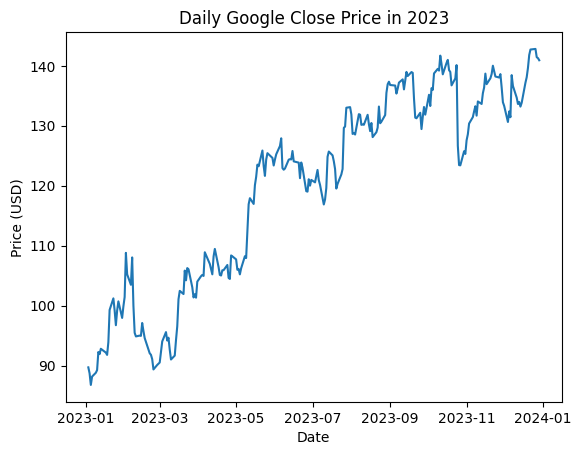

In [4]:
plt.plot(google_data_daily["Close"])
plt.title("Daily Google Close Price in 2023")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [5]:
candlestick = create_candlestick(google_data_daily)

fig = go.Figure(data=[candlestick])
fig.update_layout(
    # include only weekdays
    xaxis={"rangebreaks": [{"bounds": ["sat", "mon"]}]},
    title={"text": "Daily Google Close Price in 2023", "x": 0.5},
    xaxis_title="Date",
    yaxis_title="Price (USD)",
)

fig.show()

## Resampling

Sometimes it is useful to resample stock data to different time granularities. This can be done easily using the `.resample` method. It is also possible to obtain the different granularities directly using `yfinance`, though this may not always be possible.

In [6]:
# resampling to weekly
google_data_resampled = google_data_daily.resample("W").agg(
    {"Open": "first", "High": "max", "Low": "min", "Close": "last"}
)

In [7]:
google_data_resampled.head()

,Open,High,Low,Close
Date,,,,
2023-01-08,89.830002,91.550003,85.570000,88.160004
2023-01-15,89.195000,92.980003,86.699997,92.800003
2023-01-22,92.779999,99.419998,90.839996,99.279999
2023-01-29,99.129997,101.580002,95.262001,100.709999
2023-02-05,98.745003,108.820000,97.519997,105.220001


In [8]:
# note that start and end weeks may be incomplete
candlestick = create_candlestick(google_data_resampled)

fig = go.Figure(data=[candlestick])
fig.update_layout(
    title={"text": "Weekly Google Close Price in 2023", "x": 0.5},
    xaxis_title="Date",
    yaxis_title="Price (USD)",
)

fig.show()

In [9]:
# compare to weekly data directly from yfinance

google_data_weekly = yf.download(
    "GOOG", interval="1wk", start="2023-01-01", end="2024-01-01"
)

candlestick = create_candlestick(google_data_weekly)

fig = go.Figure(data=[candlestick])
fig.update_layout(
    title={"text": "Weekly Google Close Price in 2023", "x": 0.5},
    xaxis_title="Date",
    yaxis_title="Price (USD)",
)

fig.show()

[*********************100%***********************]  1 of 1 completed


## Plotting Returns

Returns is one of the most important metrics in finance. It is useful to calculate, plot anf analyse daily returns (or whichever time granularity is being used). It is easy to calculate returns from a price column (in our case, the 'Close' column) by using the `.pct_change` method. It can then be visualised as a time series or as a histogram.



In [10]:
# calculate daily returns
google_data_daily["daily_return"] = (
    google_data_daily["Close"].pct_change() * 100
)

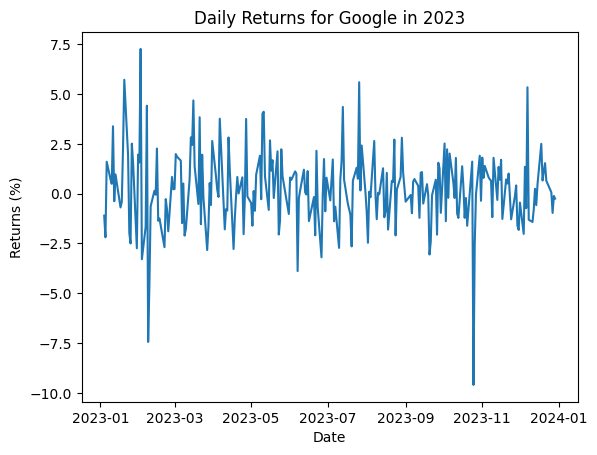

In [11]:
plt.plot(google_data_daily["daily_return"])
plt.title("Daily Returns for Google in 2023")
plt.xlabel("Date")
plt.ylabel("Returns (%)")
plt.show()

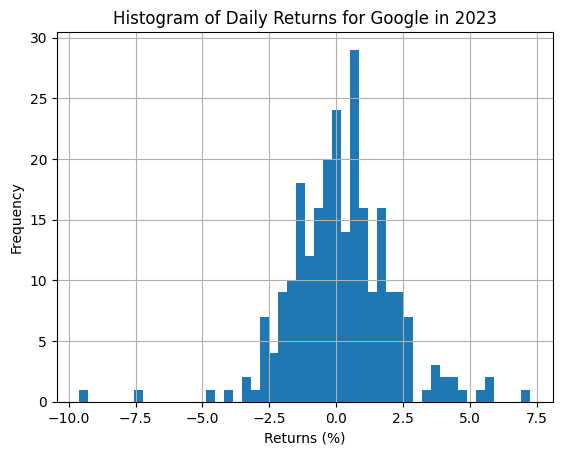

In [12]:
google_data_daily["daily_return"].hist(bins=50)
plt.title("Histogram of Daily Returns for Google in 2023")
plt.xlabel("Returns (%)")
plt.ylabel("Frequency")
plt.show()

## Statistical Tests on Returns

Performing time series analysis on returns or asset price is also very useful. In strategies such as mean reversion it may be useful to conduct tests for statistical proprties such as heteroskedasticity, autocorrelation and normality. Such tests are trialed in this section. First, we will fit a simple linear regression to the returns data, using time as the explanatory (independant) variable. 

Since the tests we use are frequentist in nature, we will apply a significance level of $0.05$.

In [13]:
# fitting a linear model
google_data_daily.dropna(inplace=True)

google_data_daily["time_numeric"] = np.arange(len(google_data_daily))

X = sm.add_constant(google_data_daily["time_numeric"])
model = sm.OLS(google_data_daily["daily_return"], X).fit()

google_data_daily["predicted_close"] = model.predict(X)
google_data_daily["residuals"] = model.resid

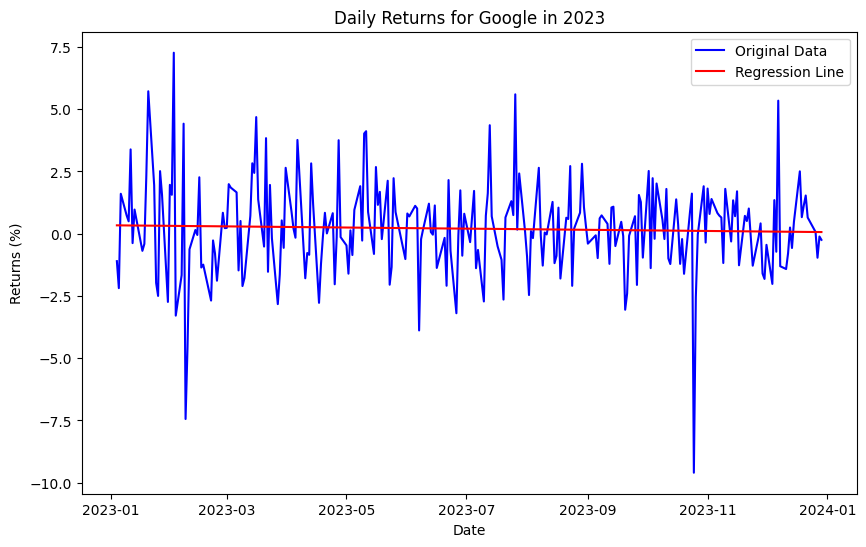

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(
    google_data_daily.index,
    google_data_daily["daily_return"],
    label="Original Data",
    color="blue",
)
plt.plot(
    google_data_daily.index,
    google_data_daily["predicted_close"],
    label="Regression Line",
    color="red",
)
plt.title("Daily Returns for Google in 2023")
plt.xlabel("Date")
plt.ylabel("Returns (%)")
plt.legend()
plt.show()

### Testing for Heteroskedasticity

In the context of a time series, heteroskedasticity means that the variance of the measured variable changes over time. The [Bresch-Pagan Test](https://www.jstor.org/stable/1911963) can be used to test for this. It is a frequentist test where the null hypothesis is that the time series is homoskedastic, i.e. the variance is constant, and the alternative is that heteroskedasticity is present.

In [15]:
# testing for homoskedasticity
bp_test = het_breuschpagan(google_data_daily["residuals"], X)

labels = ["LM Statistic", "LM Test p-value", "F-Statistic", "F-Test p-value"]
for label, value in zip(labels, bp_test):
    print(f"{label}: {value}")

LM Statistic: 3.854820442221614
LM Test p-value: 0.049603235956077435
F-Statistic: 3.8839868315841235
F-Test p-value: 0.04986528404191279


Since the p-value falls below the the significance threshold of 0.05 we reject the null hypothesis and can condlude that heteroskedasticity is present in the data and that the variance varies over time.

### Testing for Autocorrelation
The [Ljung-Box](https://www.jstor.org/stable/2284333) test is designed to test whether or not the variable in question is correlated with itself lagged over a certain time period, a property that is called autocorrelation. The null hypothesis is that autotocorrelation. is not present and the data are independently distributed, whilst the alternative hypoethesis is that autocorrelation is present.

We will test for autocorrelation over one day, 5 days, 10 days and 30 days.

In [16]:
# testing for autocorrelation
ljung_box_results = acorr_ljungbox(
    google_data_daily["daily_return"], lags=[1, 5, 10, 30], return_df=True
)
print(ljung_box_results)

      lb_stat  lb_pvalue
1    0.490813   0.483565
5    3.922617   0.560610
10   7.851724   0.643318
30  37.584541   0.160710


Since each p-value is greater than 0.05, we fail to reject the null hypothesis. This indicates that there is insufficient evidence to suggest the presence of autocorrelation in the data. In other words, the percentage returns at one time point do not have a statistically significant influence on the returns at future time points, whether it's 1 day, 5 days, 10 days, or 30 days later.

### Testing for Normality
The [Jarque-Bera](https://www.sciencedirect.com/science/article/abs/pii/0165176580900245?via%3Dihub) test for normality examines whether the skewness and kurtosis of the observed data align with those of a normal distribution (0 for skewness and 3 for kurtosis). The null hypothesis assumes normality, while the alternative hypothesis suggests that the data deviate from this, either through differing skewness or kurtosis. This test is particularly useful in time series analysis, as knowing the data's distribution allows us to quantify risk and apply appropriate models. In our case, we will apply the test to the daily returns.

In [17]:
# testing for normality
_, jb_pvalue = jarque_bera(google_data_daily["daily_return"])

print("p-value:", jb_pvalue)

p-value: 2.1517495376416485e-31


Since the p-value is below 0.05 we can reject the null hypothesis and conclude that the daily returns are not normally distributed

## Moving Averages

A simple moving average (SMA) calculates the average of the previous $n$ periods (days in our case). An exponential moving average (EMA) gives more weight to recent data, making it more responsive to recent changes. We will compare both the SMA and EMA for the close price for 5, 20 and 50 days.

In [18]:
google_data_daily["SMA_5"] = google_data_daily["Close"].rolling(5).mean()
google_data_daily["SMA_20"] = google_data_daily["Close"].rolling(20).mean()
google_data_daily["SMA_50"] = google_data_daily["Close"].rolling(50).mean()

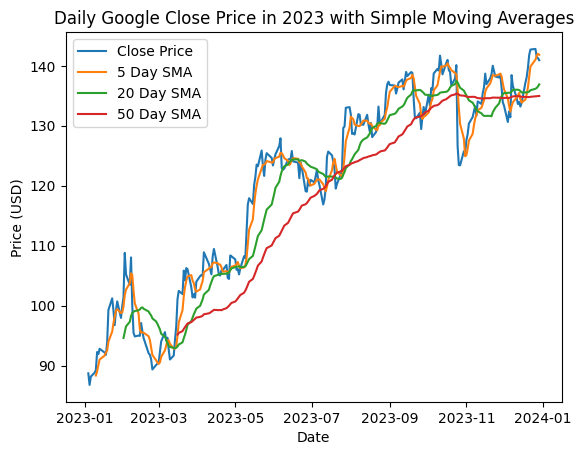

In [19]:
plt.plot(google_data_daily["Close"], label="Close Price")
plt.plot(google_data_daily["SMA_5"], label="5 Day SMA")
plt.plot(google_data_daily["SMA_20"], label="20 Day SMA")
plt.plot(google_data_daily["SMA_50"], label="50 Day SMA")
plt.legend()
plt.title("Daily Google Close Price in 2023 with Simple Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [20]:
google_data_daily["EMA_5"] = (
    google_data_daily["Close"].ewm(span=5, adjust=False).mean()
)
google_data_daily["EMA_20"] = (
    google_data_daily["Close"].ewm(span=20, adjust=False).mean()
)
google_data_daily["EMA_50"] = (
    google_data_daily["Close"].ewm(span=50, adjust=False).mean()
)

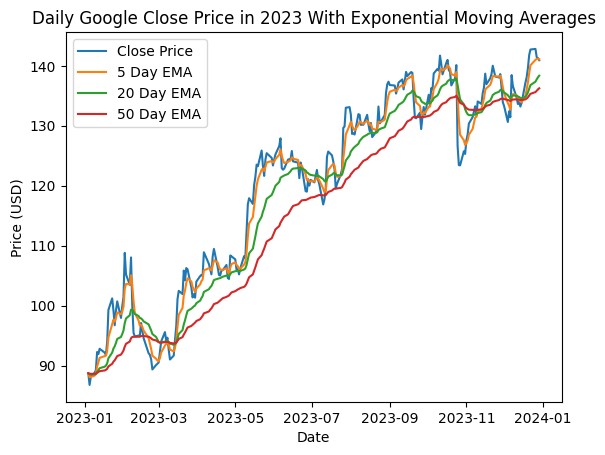

In [21]:
plt.plot(google_data_daily["Close"], label="Close Price")
plt.plot(google_data_daily["EMA_5"], label="5 Day EMA")
plt.plot(google_data_daily["EMA_20"], label="20 Day EMA")
plt.plot(google_data_daily["EMA_50"], label="50 Day EMA")
plt.legend()
plt.title("Daily Google Close Price in 2023 With Exponential Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

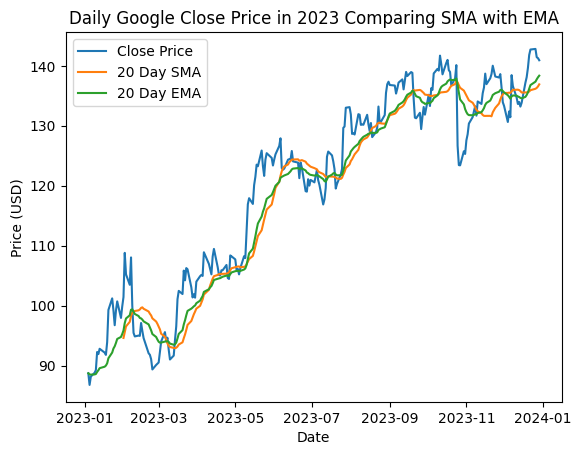

In [22]:
plt.plot(google_data_daily["Close"], label="Close Price")
plt.plot(google_data_daily["SMA_20"], label="20 Day SMA")
plt.plot(google_data_daily["EMA_20"], label="20 Day EMA")
plt.legend()
plt.title("Daily Google Close Price in 2023 Comparing SMA with EMA")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

As expected, the smaller the lookback period, the closer the moving average lines hug the data. Also the EMA responds quicker to sharp changes in price.

## Next Steps

Now that we have established the basics we can proceed to experiment with some simple strategies.